# Regresii

Intr-o problema de <i>regresie</i>, scopul este sa prezicem output-ul unei valori continue, precum un pret sau o probabilitate. Este diferita de o problema de <i>clasificare</i>, unde preziceam o clasa dintr-o multime **discreta** de clase posibile.

In acest exemplu vom folosi dataset-ul **Auto MPG**, care este o varianta putin modificata a darasetului de la StatLib. Datasetul va contine consumptia de combustibil a unor masini din anii 1970 si 1980 (in mile pe galon - miles per gallon). Vom lucra cu 3 atribute discrete si 5 atribute continue (precum nr. de cilindri, horsepower, greutate etc.)

In [252]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

In [253]:
np.set_printoptions(precision=3, suppress=True) # make NumPy printouts easier to read

In [254]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("TensorFlow version installed: ", tf.__version__)

TensorFlow version installed:  2.12.0


In [255]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data' # url-ul din care vom prelua datasetul
columns = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin'] # atributele cu care vom lucra

rawDataset = pd.read_csv(url, names=columns, na_values = '?', comment='\t', sep=' ', skipinitialspace=True) # citim din .csv folosind pandas
dataset = rawDataset.copy()
dataset.tail() # afisam cateva date din sfarsitul .csv-ului

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [256]:
dataset = dataset.dropna() # stergem intrarile in care exista date necunoscute

In datasetul nostru, avem o coloana numita _Origin_. Aceasta va contine valori intregi ce se refera la tara de origine a fiecarei masini. Va fi nevoie sa mapam fiecare integer unui string cu numele tarii, iar apoi sa folosim pandas pentru a "encoda" valorile intr-un set boolean.

In [257]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep = '')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


Acum putem observa ca au aparut coloane pentru fiecare regiune (Europa, Japonia, SUA) - iar valorile luate sunt _True_ sau _False_.

Pentru a antrena un Machine Learning Model, va trebui sa facem rost de un training dataset is un test dataset. Proportia de intrari in fiecare dataset e de obicei aproximativ **80% training / 20% test**. Training dataset se va folosi pentru a antrena propriu-zis modelul, iar test dataset pentru a verifica corectitudinea/precizia modelului.<br>
Din cei 80% de intrari de test, se mai iau **inca 20%** pentru datasetul de validare care este folosit in procesul de antrenare.

In [258]:
trainDataset = dataset.sample(frac=0.8, random_state=0)
testDataset = dataset.drop(trainDataset.index)

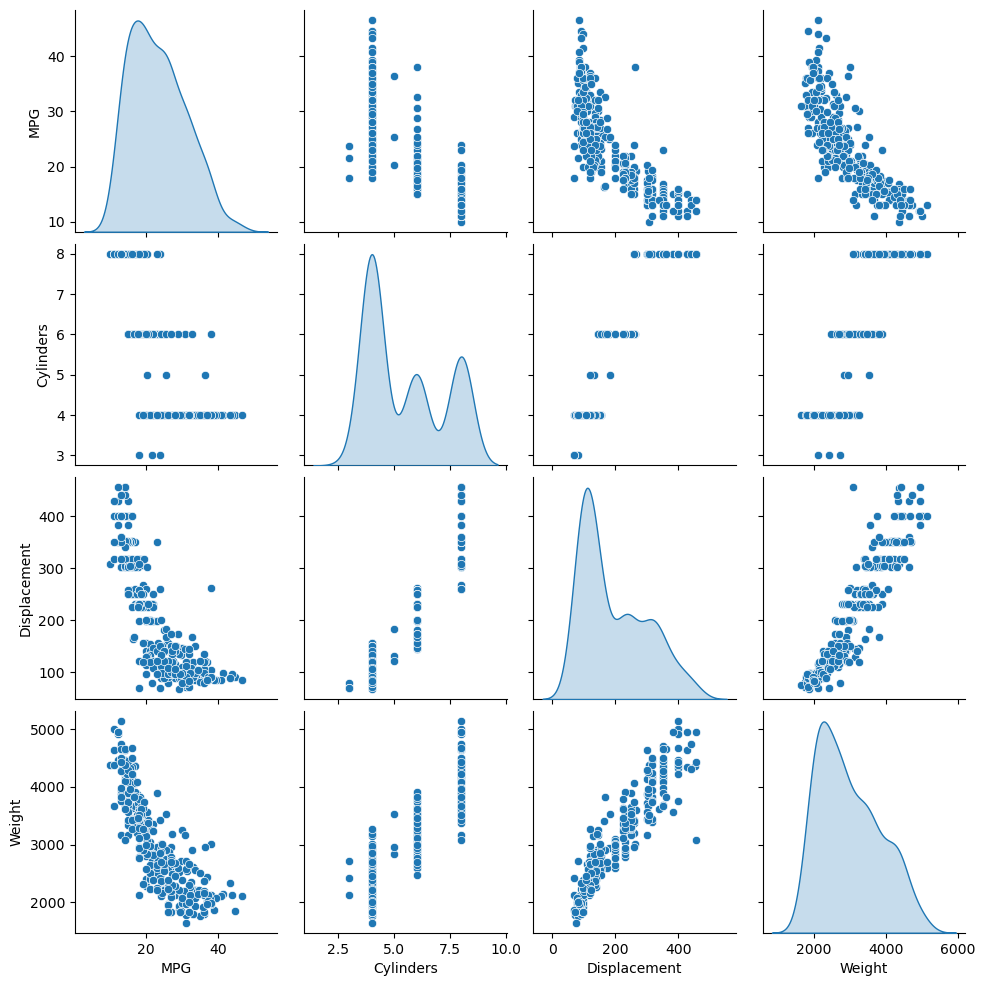

In [259]:
sb.pairplot(trainDataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde') # afisam distributtia atributelor din dataset-ul de antrenare


<b style="color: red">!</b> MPG - Miles per Gallon aka **Fuel Efficiency** este o functie ce depinde de **toti** ceilalti parametri (asta reiese din primul rand de grafice). Celelalte randuri sugereaza ca alti parametri depin unul de altul.

In [260]:
trainDataset.describe().transpose() # afisam statistica generala pentru fiecare atribut
# Putem observa ca fiecare atribut este distribuit pe intervale diferite
# Felul in care este distribuit fiecare atribut nu este, insa, de interes

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [261]:
trainFeatures = trainDataset.copy()
testFeatures = testDataset.copy()
trainLabels = trainFeatures.pop("MPG")
testLabels = testFeatures.pop("MPG")
# Scoatem atributul "MPG" din dataset-uri - acesta va fi atributul pe care vrem ca modelul sa il prezica

In [262]:
trainDataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


^ Aici am afisat media fiecarui atribut (mean - medie), impreuna cu Standard Deviation (std din functie).
Standard Deviation este _Abaterea Standard_, notata cu σ (sigma mic) - care este radical din varianta unei variabile.

$$
\sigma = \sqrt{E(X^2) - (E(X))^2}
$$
unde
- $\sigma $  ---  abaterea standard
- E(X) --- media variabilei X

Considerand ca distributiile atributelor sunt atat de diferite, va fi nevoie sa le normalizam. <br>Intr-o retea neuronala, fiecare valoare de input este inmultita cu un **weight**, ceea ce afecteaza output-ul. De aceea ar fi bine sa normalizam (scalam) valorile incat modelul nostru sa poata functiona corect si efecient. 
<br><br> <small>*Exista exceptii in care un model _poate_ converge si fara sa normalizam datele, dar este de preferat sa efectuam scalarea datasetului pentru a stabiliza procesul de antrenare.</small>

In [263]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(trainFeatures.astype(np.float32)) # Convertim datele din trainFeatures la float32 pentru ca nu putem normaliza cu booleans
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [264]:
first = np.array(trainFeatures[:1]).astype(np.float32)

with np.printoptions(precision=2, suppress=True):
    print("First example: ", first)
    print()
    print("Normalized: ", normalizer(first).numpy())

First example:  [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized:  [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Regresia Liniara
Inainte sa construim un deep neural network model, va trebui sa incepem cu o regresie liniara ce foloseste una sau mai multe variabile.
### Vom incepe cu o singura variabila
Mai intai o sa incercam sa folosim regresia liniara pentru a prezice _MPG_ din _Horsepower_.<br><br>
Folosind <a href="https://www.tensorflow.org/api_docs/python/tf/keras">tf.keras</a> incepem antrenarea unui model prin definirea arhitecturii acestuia. Aici vom folosi <a>tf.keras.Sequential</a>.
<br><br>
Vom avea 2 pasi in modelul de regresie liniara cu o singura variabila:
1. Normalizam _Horsepower_ folosing layer-ul de preprocesare <a>tf.keras.layers.Normalization</a>
2. Aplicam o transformare liniara ($y = mx + b$) ca sa producem un singur output folosind un layer linear, anume <a>tf.keras.layers.Dense</a>.


In [265]:
horsepower = np.array(trainFeatures['Horsepower'])
horsepowerNormalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepowerNormalizer.adapt(horsepower)

In [266]:
horsepowerModel = tf.keras.Sequential([
    horsepowerNormalizer,
    layers.Dense(units=1)
])

horsepowerModel.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_19 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_53 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [267]:
horsepowerModel.predict(horsepower[:10]) # rulam modelul *neantrenat* pe primele 10 valori pt cai putere. Output-ul va fi, desigur, gresit - modelul nu a fost antrenat inca

1/1 [==============================] - 0s 54ms/step


array([[-1.031],
       [-0.582],
       [ 1.903],
       [-1.445],
       [-1.307],
       [-0.513],
       [-1.549],
       [-1.307],
       [-0.341],
       [-0.582]], dtype=float32)

In [268]:
horsepowerModel.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1),
    loss = 'mean_absolute_error'
)

^ Configuram procedura de antrenare pentru modelul nostru folosind <a>Model.compile</a> din Keras. Argumentele importante sunt:
- <span style="color: green">loss</span> <br> Reprezinta ce anume vrem sa optimizam. In cazul nostru, eroarea medie absoluta.<br><br>
- <span style="color: green">optimizer</span>  <br> Reprezinta algoritmul pe care il vom folosi pentru optimizare. In cazul nostru, algoritmul Adam.

In [269]:
%%time

history = horsepowerModel.fit(
    trainFeatures["Horsepower"],
    trainLabels,
    epochs = 100,
    verbose = 0, # supress logging
    validation_split = 0.2 # luam 20% din datasetul de antrenare pentru a crea un dataset de validare
)

CPU times: user 4.19 s, sys: 113 ms, total: 4.3 s
Wall time: 3.96 s


In [270]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail() # afisam progresul spre sfarsitul antrenarii modelului

,loss,val_loss,epoch
95,3.805765,4.193195,95
96,3.804662,4.184076,96
97,3.802975,4.200578,97
98,3.802570,4.192728,98
99,3.809632,4.182898,99


In [271]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, 10])
    plt.xlabel("Epoch")
    plt.ylabel("Error [MPG]")
    plt.legend()
    plt.grid(True)

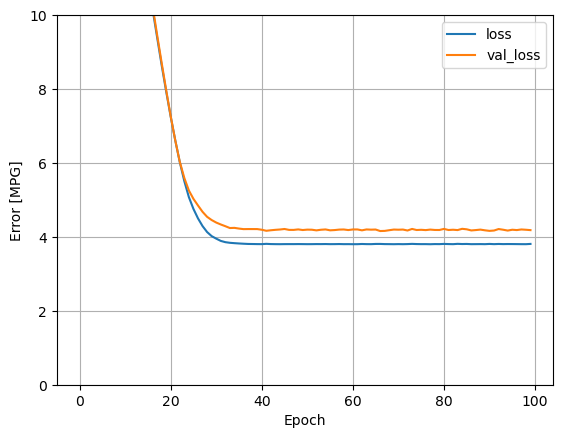

In [272]:
plot_loss(history)

In [273]:
testResults = {}

testResults["horsepowerModel"] = horsepowerModel.evaluate(
    testFeatures["Horsepower"],
    testLabels, verbose=0
)

# Salvam rezultatele pentru test set (le vom folosi putin mai tarziu)

In [274]:
x = tf.linspace(0.0, 250, 251)
y = horsepowerModel.predict(x)
# Fiind regresie de o singura variabila, putem privi predictia modelului ca pe o functie ce depinde de input

8/8 [==============================] - 0s 1ms/step


In [275]:
def plot_horsepower(x, y):
    plt.scatter(trainFeatures["Horsepower"], trainLabels, label="Data")
    plt.plot(x, y, color="k", label="Predictions")
    plt.xlabel("Horsepower")
    plt.ylabel("MPG")
    plt.legend()

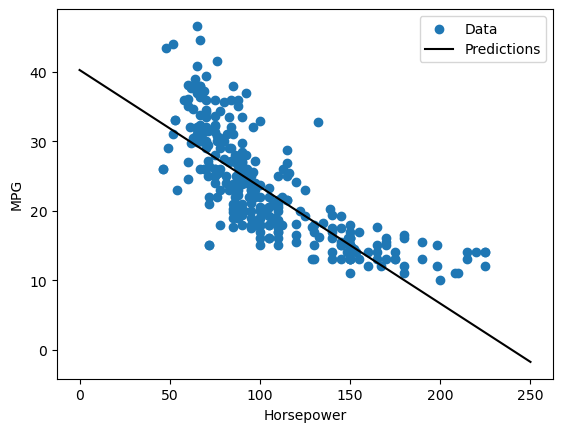

In [276]:
plot_horsepower(x, y)

### Regresie liniara cu mai multe variabile
Setup-ul pentru predictii bazate pe mai multe input-uri este aproape identic cu cel anterior. Vom folosi aceeasi functie de activare $ y = mx + b $ insa de data asta $m$ va fi o _matrice_ iar $x$ va fi un _vector_.<br><br>
Vom creea un model secvential Keras cu 2 pasi, primul layer fiind un _normalizator_.

In [277]:
linearModel = tf.keras.Sequential([
    normalizer, layers.Dense(units=1)
])

In [278]:
linearModel.predict(trainFeatures[:10].astype(np.float32))

1/1 [==============================] - 0s 45ms/step


array([[-0.814],
       [ 1.324],
       [-0.878],
       [ 0.731],
       [ 1.072],
       [ 1.086],
       [ 1.195],
       [ 3.09 ],
       [-0.063],
       [ 0.068]], dtype=float32)

In [279]:
linearModel.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss = "mean_absolute_error"
)

In [280]:
%%time
history = linearModel.fit(
    trainFeatures.astype(np.float32),
    trainLabels,
    epochs = 100,
    verbose = 0,
    validation_split = 0.2
)

CPU times: user 4.03 s, sys: 138 ms, total: 4.17 s
Wall time: 3.84 s


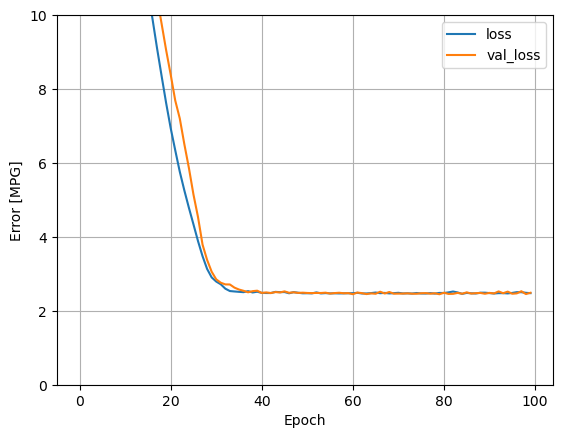

In [281]:
plot_loss(history)

3/3 [==============================] - 0s 2ms/step


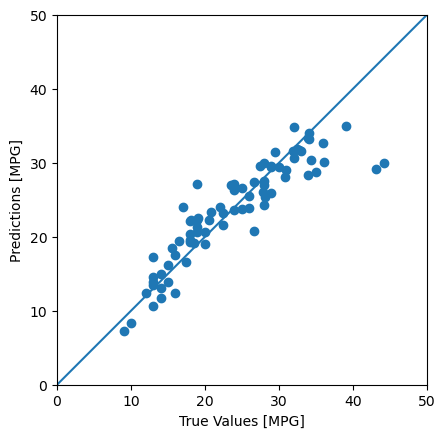

In [282]:
testPredictions = linearModel.predict(testFeatures.astype(np.float32)).flatten()
a = plt.axes(aspect="equal")
plt.scatter(testLabels, testPredictions)
plt.xlabel("True Values [MPG]")
plt.ylabel("Predictions [MPG]")
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [283]:
testResults["linearModel"] = linearModel.evaluate(
    testFeatures.astype(np.float32), testLabels, verbose = 0
)

### Regresii cu un Deep Neural Network (DNN) cu o variabila
Pana acum am implementat 2 modele lineare: pentru un singur input si pentru mai multe inputuri.
Acum putem implementa **modele DNN** de tip single-input si multiple-input.
<br><br>
Codul este aproape acelasi. Principala schimbare este faptul ca vom include mai multe layere "ascunse" nelineare (care nu sunt conectate in mod direct la input sau output).
<br><br>
In aceste modele vom avea urmatoarele layere:
- Normalization Layer (ca si in exemplul precedent)
- Non-Linear Hidden Layer (x2) - vor fi straturi _Dense_ cu functia de activare _ReLU_ (**Re**ctified **L**inear **U**nit)
- Linear Dense single-output Layer

Ambele modele vor folosi aceeasi procedura de antrenare, asa ca ar fi mai eficient sa construim o functie pentru asta:

In [284]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [285]:
horsepowerModelDNN = build_and_compile_model(horsepowerNormalizer)
horsepowerModelDNN.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_19 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_55 (Dense)            (None, 64)                128       
                                                                 
 dense_56 (Dense)            (None, 64)                4160      
                                                                 
 dense_57 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [286]:
%%time
history = horsepowerModelDNN.fit(
    trainFeatures["Horsepower"],
    trainLabels,
    validation_split = 0.2,
    verbose=0,
    epochs = 100
)

CPU times: user 1min, sys: 1min 12s, total: 2min 13s
Wall time: 19.5 s


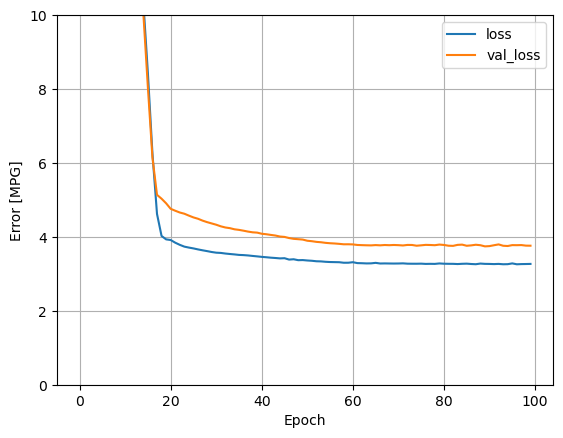

In [287]:
plot_loss(history)

8/8 [==============================] - 0s 14ms/step


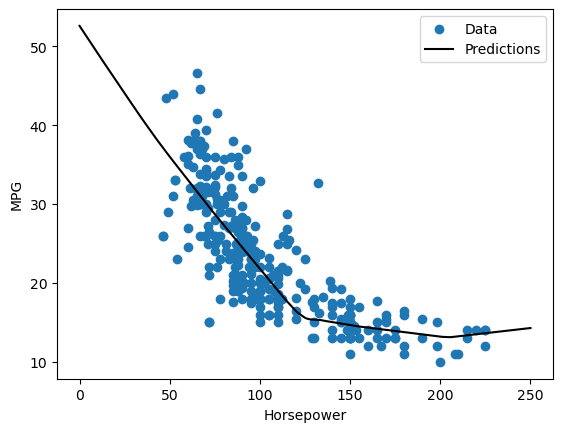

In [288]:
x = tf.linspace(0.0, 250, 251) # tf.linspace genereaza o discretizare. Parametrii sunt start, stop si nr de puncte
y = horsepowerModelDNN.predict(x)

plot_horsepower(x, y)

^ Ca si in exemplul cu modelele liniare, am plotat predictiile in functie de inputuri. Putem observa efectul celor 2 straturi neliniare, care maresc semnificativ precizia modelului.

In [289]:
testResults["horsepowerModelDNN"] = horsepowerModelDNN.evaluate(
    testFeatures["Horsepower"],
    testLabels,
    verbose = 0
)

### Regresii cu un DNN - mai multe variabile

In [290]:
dnnModel = build_and_compile_model(normalizer)
dnnModel.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_18 (Normaliza  (None, 9)                19        
 tion)                                                           
                                                                 
 dense_58 (Dense)            (None, 64)                640       
                                                                 
 dense_59 (Dense)            (None, 64)                4160      
                                                                 
 dense_60 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [291]:
%%time
history = dnnModel.fit(
    trainFeatures.astype(np.float32),
    trainLabels,
    epochs = 100,
    verbose = 0,
    validation_split = 0.2
)

CPU times: user 58 s, sys: 1min 12s, total: 2min 10s
Wall time: 19 s


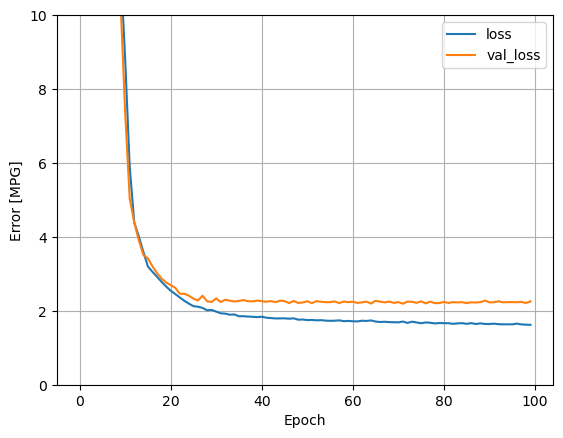

In [292]:
plot_loss(history)

In [293]:
testResults["dnnModel"] = dnnModel.evaluate(testFeatures.astype(np.float32), testLabels, verbose=0)
pd.DataFrame(testResults, index=["Mean absolute error [MPG]"]).T

,Mean absolute error [MPG]
horsepowerModel,3.634336
linearModel,2.503695
horsepowerModelDNN,2.951267
dnnModel,1.653406


3/3 [==============================] - 0s 12ms/step


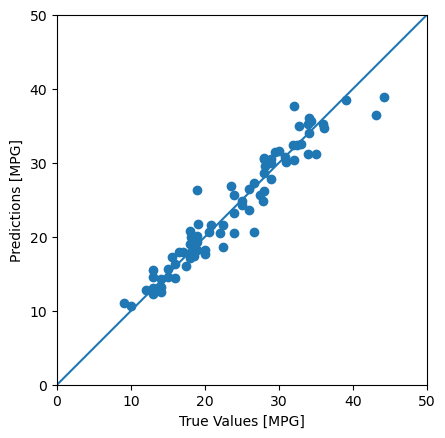

In [294]:
testPredictions = dnnModel.predict(testFeatures.astype(np.float32)).flatten()
a = plt.axes(aspect="equal")
plt.scatter(testLabels, testPredictions)
plt.xlabel("True Values [MPG]")
plt.ylabel("Predictions [MPG]")
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

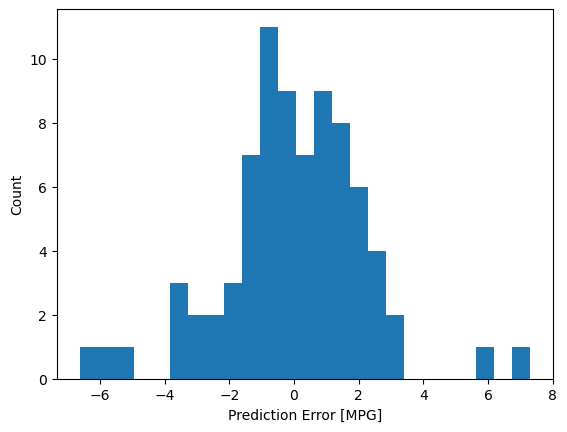

In [295]:
error = testPredictions - testLabels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")